In [1]:
%load_ext autoreload
%autoreload 2
import os
import sr_mcmc as srmc
import argparse
import config_lib as cl
import deathTimesDataSet as dtds
import ast
import readResults as rr
import readResultsBaysian as rrb
import corner
import matplotlib.pyplot as plt
import matplotlib
import SRmodellib as sr
import SRmodellib_lifelines as srl
import emcee
import numpy as np
import SR_hetro as srh

In [2]:
#get list of all config directories. all directories in the configs directory that start with configs
def getConfigDirs(parent_dir='configs',ignore = []):
    configDirs = []
    for dir in os.listdir(parent_dir):
        if dir.startswith('config') and dir not in ignore:
            configDirs.append(os.path.join(parent_dir,dir))
    return configDirs


def get_dataSets_and_best_sims(configDirs,resultDir):
    dataSets = {}
    bestSims = {}
    time_ranges = {}
    values = {}
    current_folder = os.path.basename(os.getcwd())    
    for configDir in configDirs:
        print("At config: ", configDir)
        config = cl.read_configs(configDir)
        nsteps = int(config.get('DEFAULT', 'nsteps'))
        npeople = int(config.get('DEFAULT', 'npeople'))
        t_end = int(config.get('DEFAULT', 't_end'))
        nwalkers = int(config.get('DEFAULT', 'nwalkers'))
        nsteps = int(config.get('DEFAULT', 'nsteps'))
        time_range = ast.literal_eval(config.get('DEFAULT', 'time_range'))
        time_step_multiplier = int(config.get('DEFAULT', 'time_step_multiplier'))
        data_file = config.get('DEFAULT', 'data_file')
        results_csv_file_name = config.get('DEFAULT', 'results_csv_file_name')
        hetro = config.getboolean('DEFAULT', 'hetro',fallback=False)
        external_hazard = ast.literal_eval(config.get('DEFAULT', 'external_hazard'))
        #all paths are in absolute paths (start with ~/). change all paths to be relative to the current folder 
        # (remove everything before the current folder name)
        data_file = data_file.split(current_folder)[-1]
        #remove the first / from the paths
        data_file = data_file[1:]
        key = results_csv_file_name.split('.')[0]

        if key =='Mice_F':
            bandwidth = 13
        else:
            bandwidth = 3
        ds = dtds.dsFromFile(data_file,bandwidth=bandwidth)
        if resultDir[configDir].endswith('.csv'):
            theta = rrb.getTheta(resultDir[configDir])
            value = rrb.getParams(resultDir[configDir],[9])
        else:
            theta = rrb.getTheta(os.path.join(resultDir[configDir],results_csv_file_name))
            value = rrb.getParams(os.path.join(resultDir[configDir],results_csv_file_name),[9])
        if hetro:
            external_hazard =rrb.getParams(os.path.join(resultDir[configDir],results_csv_file_name),['ExtH'])
        sim = srh.getSrHetro(theta,nsteps=nsteps, npeople=npeople, time_step_multiplier=time_step_multiplier, t_end=t_end, external_hazard=external_hazard, parallel=True,hetro=hetro,bandwidth=bandwidth)
        dataSets[key] = ds
        bestSims[key] = sim
        time_ranges[key] = time_range
        values[key] = value


    return dataSets, bestSims, time_ranges, values

In [3]:
# configDirs = getConfigDirs(ignore=['configs_drosophila_195and217'])
configDirs = ['configs/configs_ecoli','configs/configs_celegance','configs/DROSOPHILA/configs_drosophila_441','configs/configs_mice_F',
              'configs/DOGS/configs_Labrador_vetCompass','configs/HUMANS/configs_Denmark_M_1900']
resultsDir = {'configs/configs_ecoli':'results_csvs',
              'configs/configs_celegance':'results_csvs',
              'configs/DROSOPHILA/configs_drosophila_441':'results_csvs/DROSOPHILA/drosophila_441.csv',
              'configs/configs_mice_F':'results_csvs',
              'configs/DOGS/configs_Labrador_vetCompass':'results_csvs/DOGS/Labrador_vetCompass.csv',
              'configs/HUMANS/configs_Denmark_M_1900':'results_csvs/HUMANS'}
dataSets, bestSims, time_ranges, values = get_dataSets_and_best_sims(configDirs, resultsDir)

At config:  configs/configs_ecoli
At config:  configs/configs_celegance
At config:  configs/DROSOPHILA/configs_drosophila_441
At config:  configs/configs_mice_F
At config:  configs/DOGS/configs_Labrador_vetCompass
At config:  configs/HUMANS/configs_Denmark_M_1900


In [4]:
print(dataSets.keys())

dict_keys(['Ecoli', 'celegance', 'drosophila_441', 'Mice_F', 'Labrador_vetCompass', 'Denmark_M_1900'])


Ecoli
celegance
drosophila_441
Mice_F
Labrador_vetCompass
Denmark_M_1900


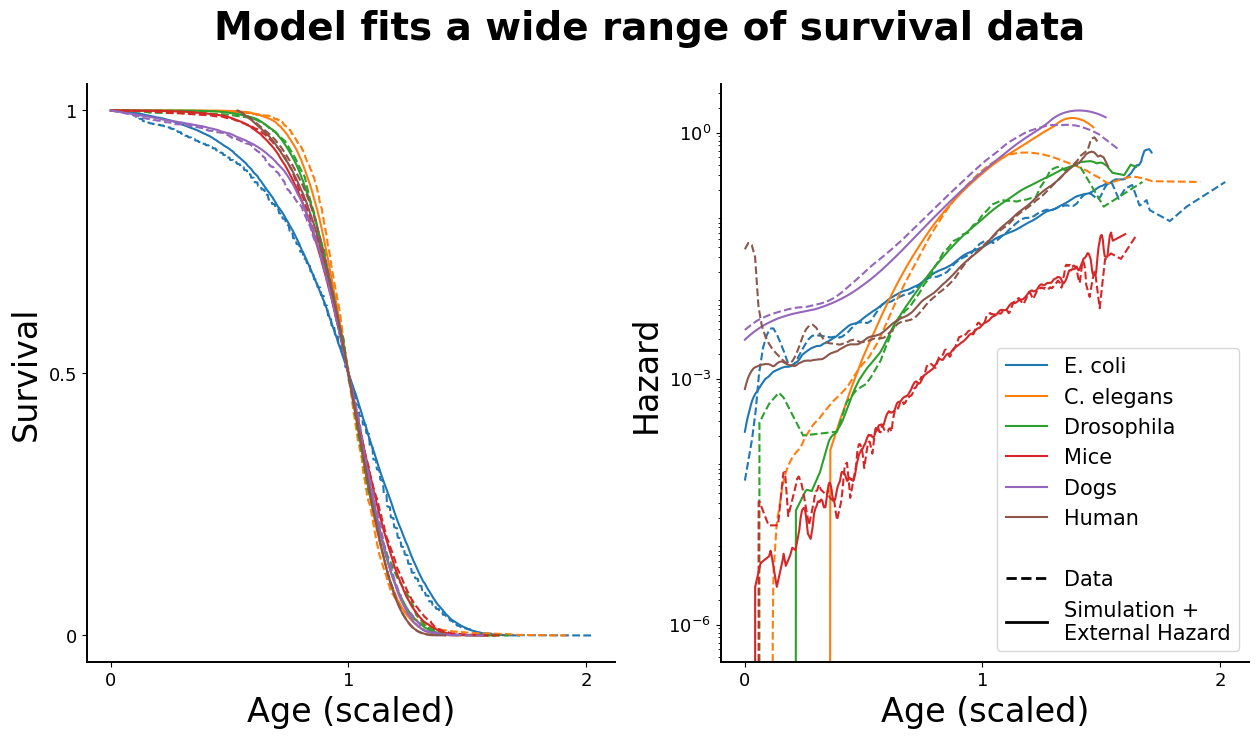

In [6]:
fig, ax = plt.subplots(1, 2, figsize=(15, 7.5))
colormap  = plt.get_cmap('tab10')

labels = {'Ecoli':'E. coli',
           'celegance': 'C. elegans',
             'drosophila_441': 'Drosophila',
               'Mice_F': 'Mice',
                 'Labrador_vetCompass': 'Dogs',
                   'Denmark_M_1900': 'Human'

}

i=0
for key in ['Ecoli', 'celegance', 'drosophila_441', 'Mice_F', 'Labrador_vetCompass', 'Denmark_M_1900']:
    print(key)
    ds = dataSets[key]
    sim = bestSims[key]
    time_range = time_ranges[key]
    value = values[key]
    

    ds.plotScaledSurvival(ax=ax[0], time_range=time_range, label='', ls='--', color=colormap(i),CI=False)
    ds.plotScaledHazard(ax=ax[1], label='', ls='--', color=colormap(i))
    scale= ds.getMedianLifetime()
    sim.plotScaledSurvival(ax=ax[0], time_range=time_range, label=labels[key], color=colormap(i),CI=False)
    sim.plotScaledHazard(ax=ax[1],scale=scale, label=labels[key], color=colormap(i))
    i+=1

legend_font = {'size':'15'}

#put legend on bottom right of the right plot. Add to legend shhowinf full line is simulation and dashed line is data
handles, labels = ax[1].get_legend_handles_labels()
handles.append(plt.Line2D([0], [0], color='white', lw=0, label=''))
handles.append(plt.Line2D([0], [0], color='black', lw=2, ls='--', label='Data'))
handles.append(plt.Line2D([0], [0], color='black', lw=2, label='Simulation +\nExternal Hazard'))
ax[1].legend(handles=handles, loc='lower right', prop=legend_font)

axis_font = {'size':'24'}
ticks_font = {'size':'13'}

#have just three ticks on each axis, add axis labels
ax[0].set_xticks([0,1,2])
ax[0].set_xticklabels([0,1,2], **ticks_font)
ax[0].set_yticks([0,0.5,1])
ax[0].set_yticklabels([0,0.5,1], **ticks_font)
ax[0].set_xlabel('Age (scaled)', **axis_font)
ax[0].set_ylabel('Survival', **axis_font)
ax[1].set_xticks([0,1,2])
ax[1].set_xticklabels([0,1,2], **ticks_font)
ax[1].set_yticks([1e-6,1e-3,1])
ax[1].set_yticklabels(['$10^{{-6}}$', '$10^{{-3}}$', '$10^{{0}}$'], **ticks_font)
ax[1].set_xlabel('Age (scaled)', **axis_font)
ax[1].set_ylabel('Hazard', **axis_font)

#make axis lines thicker
alw = 1.4
for axis in ['top','bottom','left','right']:
  ax[0].spines[axis].set_linewidth(alw)
  ax[1].spines[axis].set_linewidth(alw)

#add super title
fig.suptitle('Model fits a wide range of survival data', fontsize=28,weight='bold')

#save figure as svg
plt.savefig('plots/model_fits_different_organisms.svg', format='svg', dpi=1200)


In [4]:
#sort the dataSets and bestSims by the values
sorted_values = sorted(values.items(), key=lambda x: x[1])
sorted_dataSets = {}
sorted_bestSims = {}
sorted_time_ranges = {}
for key, value in sorted_values:
    sorted_dataSets[key] = dataSets[key]
    sorted_bestSims[key] = bestSims[key]
    sorted_time_ranges[key] = time_ranges[key]
dataSets = sorted_dataSets
bestSims = sorted_bestSims
time_ranges = sorted_time_ranges


Human_F_years
Human_M_years
Mice_F
Mice2_M
Yeast
celegance
drosophila


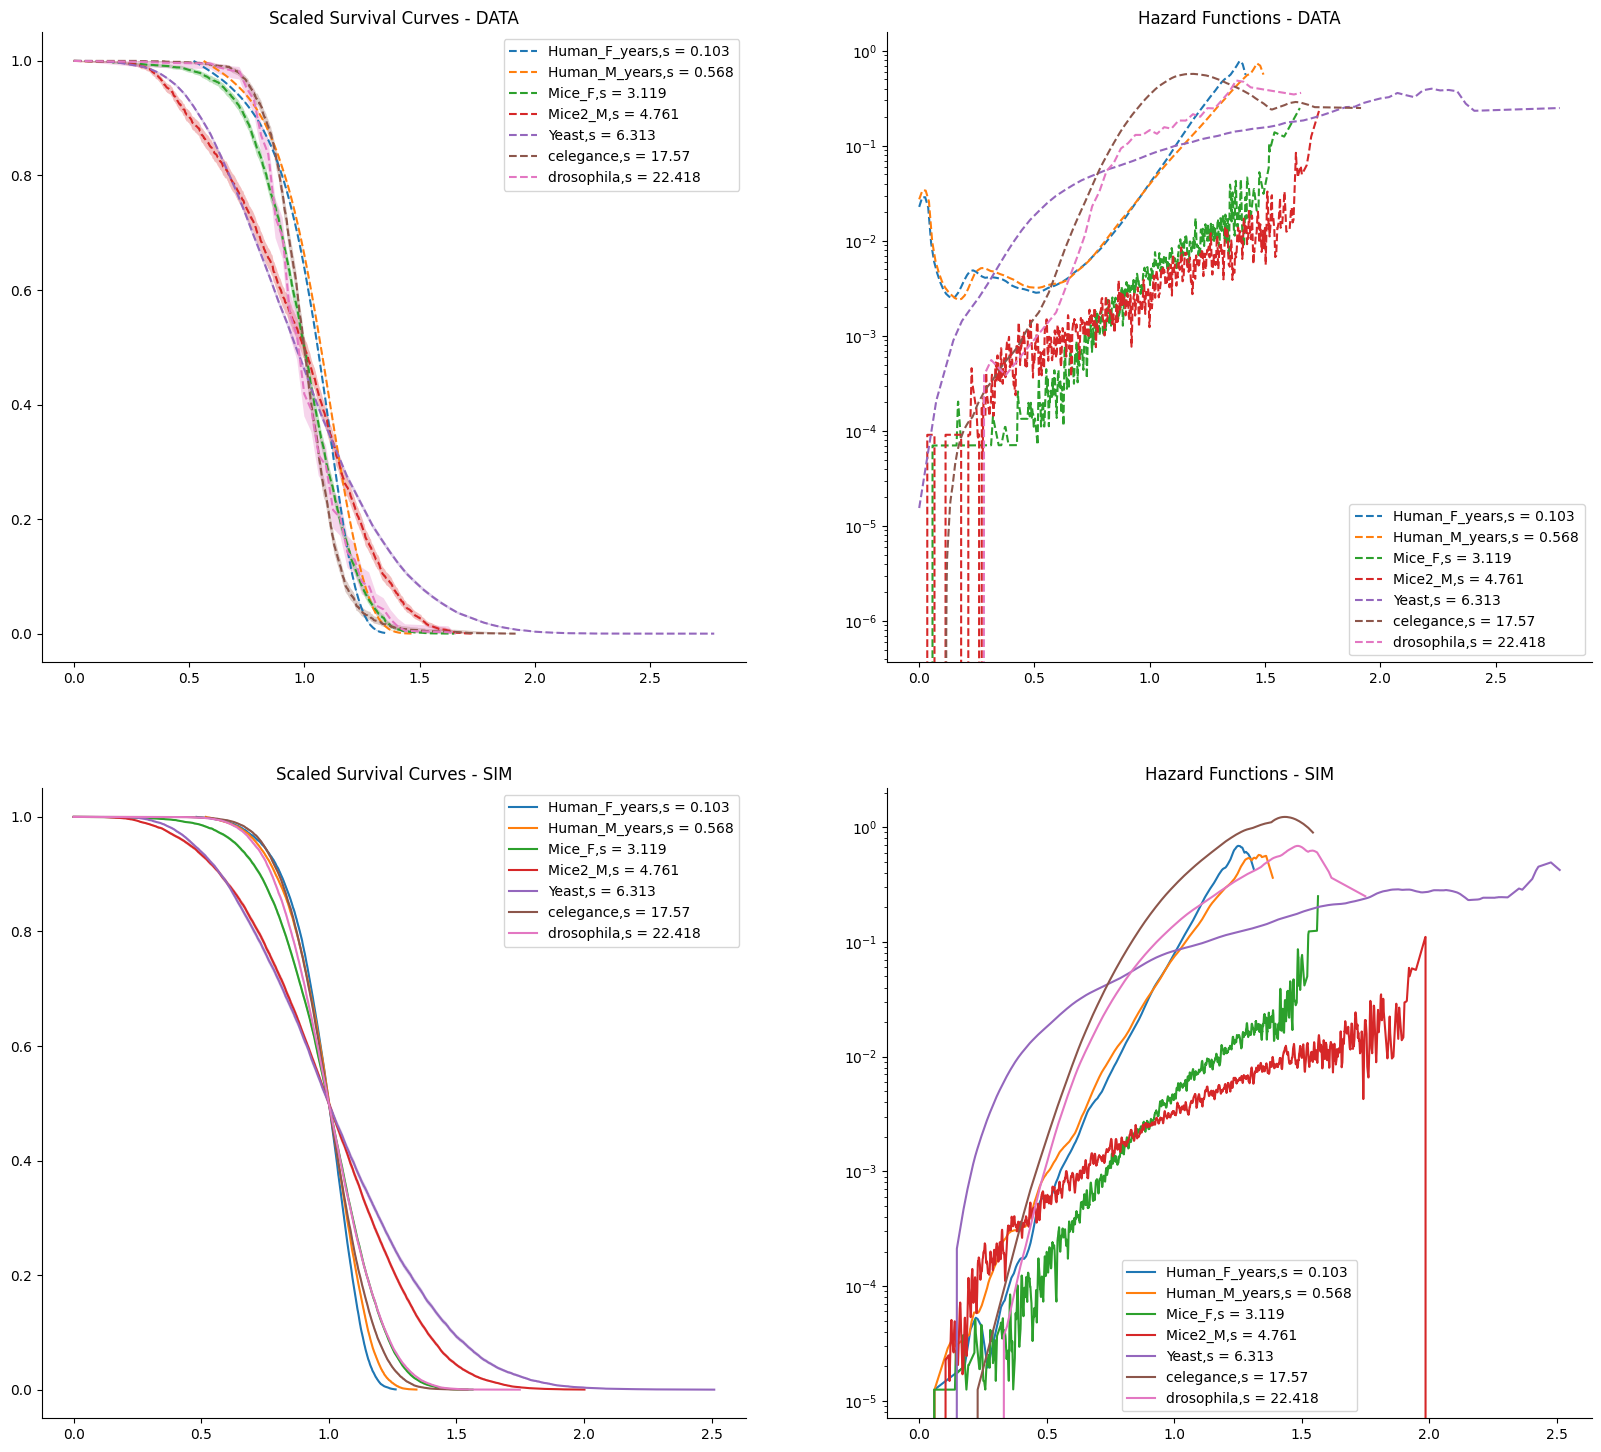

In [5]:
#plot the scaled survival curves and hazard functions for all the data sets and best simulations, labeled by the data set name
#and the value of the parameter: label = f'{key},s = {values[key]}'
fig, ax = plt.subplots(2, 2, figsize=(20, 18))
for key in dataSets:
    print(key)
    ds = dataSets[key]
    sim = bestSims[key]
    time_range = time_ranges[key]
    value = values[key]
    ds.plotScaledSurvival(ax=ax[0,0],time_range=time_range,label=f'{key},s = {value[0]}',ls='--')
    ds.plotScaledHazard(ax=ax[0,1],label=f'{key},s = {value[0]}',ls='--')
    sim.plotScaledSurvival(ax=ax[1,0],time_range=time_range,label=f'{key},s = {value[0]}')
    sim.plotScaledHazard(ax=ax[1,1],label=f'{key},s = {value[0]}')
    ax[0,1].set_yscale('log')
    ax[1,1].set_yscale('log')
    ax[0,0].set_title('Scaled Survival Curves - DATA')
    ax[0,1].set_title('Hazard Functions - DATA')
    ax[1,0].set_title('Scaled Survival Curves - SIM')
    ax[1,1].set_title('Hazard Functions - SIM')
    ax[0,0].legend()
    ax[0,1].legend()
    ax[1,0].legend()
    ax[1,1].legend()

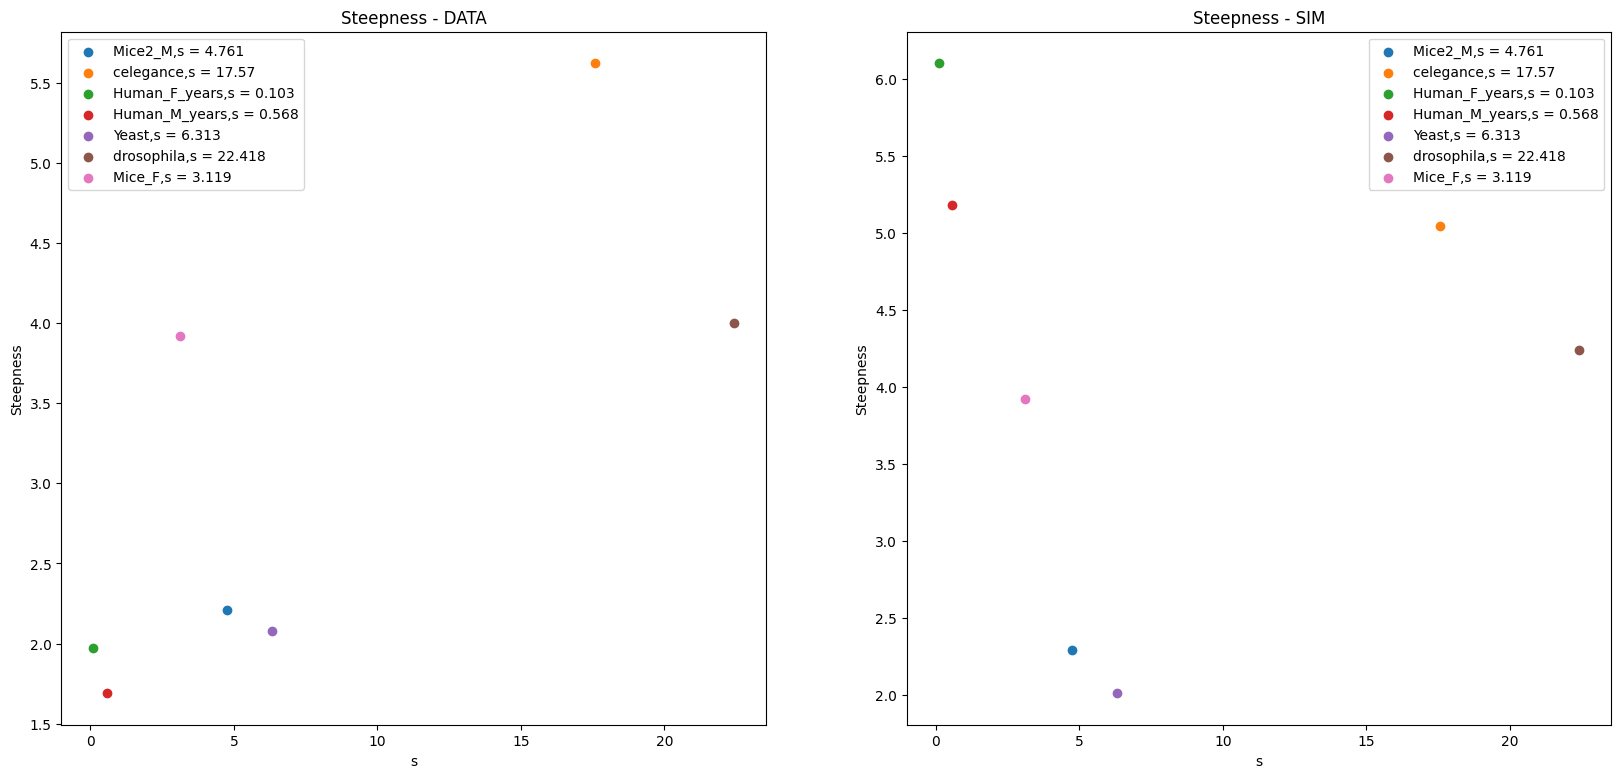

In [12]:
#plot for each data set and best simulation (on separate plots) the steepness (by getSteepness(method='AMS_Sel') vs the value of s)

fig, ax = plt.subplots(1, 2, figsize=(20, 9))
steepness_ds = {}
steepness_sim = {}
for key in dataSets:
    ds = dataSets[key]
    sim = bestSims[key]
    time_range = time_ranges[key]
    value = values[key]
    steepness_ds[key] = ds.getSteepness(method='IQR')
    steepness_sim[key] = sim.getSteepness(method='IQR')
for key in steepness_ds:
    ax[0].scatter(values[key][0],steepness_ds[key],label=f'{key},s = {values[key][0]}')
    ax[1].scatter(values[key][0],steepness_sim[key],label=f'{key},s = {values[key][0]}')
    ax[0].set_title('Steepness - DATA')
    ax[1].set_title('Steepness - SIM')
    ax[0].legend()
    ax[1].legend()
    #axis labels
    ax[0].set_xlabel('s')
    ax[1].set_xlabel('s')
    ax[0].set_ylabel('Steepness')
    ax[1].set_ylabel('Steepness')
